In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
target = 'aa2ar'
url = f'https://dude.docking.org//targets/{target}'
tables = './tables'

In [ ]:
def dataset_loader():
    active = pd.read_csv(f'{url}/actives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
    needed_active = active[active[2] == 'Ki']
    df = pd.DataFrame({'smiles':needed_active[0], 'Ki': needed_active[4]})
    return df

In [ ]:
df = dataset_loader()

### Feature generation - RDKit Library

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as MDC

In [ ]:
y = df['Ki'].reset_index()
y = y['Ki']

In [ ]:
y

In [ ]:
def RDkit_descriptors(data):
    mols = [Chem.MolFromSmiles(i) for i in data.smiles]
    desc_names = list(CalcMolDescriptors(mols[0]).keys())
    mol_descs = []
    for i in tqdm(range(len(data))):
        descriptors = CalcMolDescriptors(mols[i])
        mol_descs.append(descriptors)
    return mol_descs

In [ ]:
mol_descs,desc_names = RDkit_descriptors(df)

In [67]:
# mol_desc = pd.Series(mol_descs
# data = pd.DataFrame(mol_descs)
data.shape

(2776, 210)

In [ ]:
save = pd.concat([data, y], axis=1)
save

In [60]:
save.to_csv(f'{tables}/active_regr.csv',index=False)

In [4]:
new_df = pd.read_csv(f'{tables}/active_regr.csv')
new_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Ki
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,39.7
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,502.0
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,150.0
3,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,1.0
4,10.328997,10.328997,0.042932,-1.278885,0.279243,23.375000,460.878,439.710,460.126195,168,...,0,0,0,0,0,0,0,0,0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,10.207113,10.207113,0.176268,-1.612007,0.403557,26.640000,363.450,342.282,363.136281,134,...,0,0,0,0,0,0,0,0,0,630.0
2772,11.212685,11.212685,0.209838,-0.978555,0.322488,15.540541,521.607,494.391,521.195757,192,...,0,0,0,0,0,0,0,0,0,2.2
2773,11.747357,11.747357,0.187560,-3.317645,0.597420,11.880000,355.379,342.275,355.073910,126,...,0,1,0,0,0,0,0,0,0,110.0
2774,11.566178,11.566178,0.123217,-3.222610,0.585306,11.884615,369.406,354.286,369.089560,132,...,0,1,0,0,0,0,0,0,0,340.0


In [5]:
X = new_df.iloc[:,:-1]
y = new_df['Ki']
y

0        39.7
1       502.0
2       150.0
3         1.0
4       390.0
        ...  
2771    630.0
2772      2.2
2773    110.0
2774    340.0
2775    779.0
Name: Ki, Length: 2776, dtype: float64

NameError: name 'data' is not defined

### Filtering invariant and highly correlated features

In [7]:
del_col = []
for col in X.columns:
    if len(X[col].unique()) == 1:
        X.drop(col, inplace=True, axis=1)
        del_col.append(col)
        

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X.drop(to_drop, axis=1, inplace=True)

In [8]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,0.320010,-0.463007,1.250000,79.918731,...,0,0,0,0,0,0,0,0,0,0
1,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,0.320010,-0.463007,1.250000,79.918731,...,0,0,0,0,0,0,0,0,0,0
2,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,0.320010,-0.463007,1.250000,79.918731,...,0,0,0,0,0,0,0,0,0,0
3,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,0.220767,-0.447724,1.142857,79.918731,...,0,0,0,0,0,0,0,0,0,0
4,10.328997,0.042932,-1.278885,0.279243,23.375000,460.878,0.320010,-0.463007,1.250000,35.495692,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,10.207113,0.176268,-1.612007,0.403557,26.640000,363.450,0.207876,-0.393567,1.280000,28.331225,...,0,0,0,0,0,0,0,0,0,0
2772,11.212685,0.209838,-0.978555,0.322488,15.540541,521.607,0.224850,-0.480445,1.054054,32.197121,...,0,0,0,0,0,0,0,0,0,0
2773,11.747357,0.187560,-3.317645,0.597420,11.880000,355.379,0.217513,-0.460950,1.160000,32.227746,...,0,0,0,1,0,0,0,0,0,0
2774,11.566178,0.123217,-3.222610,0.585306,11.884615,369.406,0.222261,-0.462699,1.153846,32.227746,...,0,0,0,1,0,0,0,0,0,0


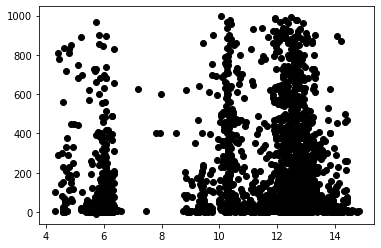

In [90]:
X_one_feat = X.iloc[:, 0]
# X_one_feat
plt.scatter(X_one_feat, y, color="black")
plt.show()

In [22]:
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge


In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [18]:
X_train

array([[ 6.99815686e-01, -5.94114008e-01,  2.96647158e-01, ...,
        -2.04150032e-01, -1.91775121e-01, -2.29589665e-01],
       [ 8.73801538e-01,  8.70291949e-01,  2.39872003e-01, ...,
        -2.04150032e-01, -1.91775121e-01, -2.29589665e-01],
       [ 7.94969169e-01,  5.20143564e-03,  2.27114725e-01, ...,
        -2.04150032e-01, -1.91775121e-01, -2.29589665e-01],
       ...,
       [ 6.04850155e-01,  8.61000314e-02,  3.98770198e-01, ...,
        -2.04150032e-01, -1.91775121e-01, -2.29589665e-01],
       [ 5.47987660e-01, -1.04958296e+00,  6.20661751e-01, ...,
         3.81514422e+00, -1.91775121e-01, -2.29589665e-01],
       [-8.22480500e-01, -8.12858128e-01,  6.51872993e-01, ...,
         7.83443847e+00, -1.91775121e-01, -2.29589665e-01]])

### Lasso

In [ ]:
lasso = Lasso(random_state=0)
alphas = np.concatenate(np.logspace(-4, -0.5, 30), [0.1, 0.5, 1])


n_folds = 5
tuned_parameters = [{"alpha": alphas}]
cv = RepeatedKFold(n_splits=n_folds, n_repeats=3, random_state=1)

lass_grid = GridSearchCV(lasso, tuned_parameters, cv=cv, refit=False)
lass_grid.fit(X, y)

In [ ]:
scores = lass_grid.cv_results_["mean_test_score"]
scores_std = lass_grid.cv_results_["std_test_score"]

In [ ]:
lass_grid.score(X_test, y_test)

In [ ]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])
plt.show()

### Ridge

In [ ]:
rigde = Ridge(random_state=0, max_iter=1000)

alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{"alpha": alphas}]
n_folds = 10
cv = RepeatedKFold(n_splits=n_folds, n_repeats=3, random_state=1)

rigde_grid = GridSearchCV(ridge, tuned_parameters, cv=cv, refit=False)
ridge_grid.fit(X, y)

In [ ]:
scores = ridge_grid.cv_results_["mean_test_score"]
scores_std = ridge_grid.cv_results_["std_test_score"]

In [ ]:
ridge_grid.score(X_test, y_test)

In [ ]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

### ElasticNet

In [ ]:
elastnet = ElasticNet(random_state=0, max_iter=1000)

alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{"alpha": alphas}]
n_folds = 10
cv = RepeatedKFold(n_splits=n_folds, n_repeats=3, random_state=1)

elastnet_grid = GridSearchCV(elastnet, tuned_parameters, cv=cv, refit=False)
elastnet_grid.fit(X, y)

In [ ]:
scores = elastnet_grid.cv_results_["mean_test_score"]
scores_std = elastnet_grid.cv_results_["std_test_score"]

In [ ]:
elastnet_grid.score(X_test, y_test)

In [ ]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

### SGDRegressor

In [ ]:
sgdreg = SGDRegressor(random_state=0, max_iter=1000)

alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{"alpha": alphas}]
n_folds = 10
cv = RepeatedKFold(n_splits=n_folds, n_repeats=3, random_state=1)

sgdreg_grid = GridSearchCV(sgdreg, tuned_parameters, cv=cv, refit=False)
sgdreg_grid.fit(X, y)

In [ ]:
scores = sgdreg_grid.cv_results_["mean_test_score"]
scores_std = sgdreg_grid.cv_results_["std_test_score"]

In [ ]:
sgdreg_grid.score(X_test, y_test)

In [ ]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

### Plot all methods

In [ ]:
from sklearn.linear_model import HuberRegressor

In [ ]:
huber = HuberRegressor(random_state=0, max_iter=1000)

alphas = np.logspace(-4, -0.5, 30)
epsilons = np.linspace(1, 4, 7)
tuned_parameters = [{"alpha": alphas, 'epsilon':epsilons}]
n_folds = 10
cv = RepeatedKFold(n_splits=n_folds, n_repeats=3, random_state=1)

huber_grid = GridSearchCV(huber, tuned_parameters, cv=cv, refit=False)
huber_grid.fit(X, y)

In [ ]:
scores = huber_grid.cv_results_["mean_test_score"]
scores_std = huber_grid.cv_results_["std_test_score"]

In [ ]:
huber_grid.score(X_test, y_test)

In [ ]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])
plt.show()